In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import readsav
import os, lmfit, glob, datetime

In [3]:
%load_ext autoreload
%autoreload 2

from DSTPolarimeterLib import MuellerMatrixRotation, MuellerMatrixMirror, MuellerMatrixWaveplate
from DSTPolarimeterLib import hd2angle

In [4]:
#--- dtor * deg = rad
dtor = 0.017453292519943295

---

# Working Space

In [7]:
pathData     = "/nwork/kouui/dstsp/data/calibration/20171128/camera01/cal"
pathCamera01 = "/nwork/kouui/dstsp/data/calibration/20171128/camera01/cal"

In [8]:
threshold=129626

read filenames

In [9]:
files = sorted( glob.glob( pathData+"*.sav" ) )
# reffiles = sorted( glob.glob( pathCamera01+"*.sav" ) )
print("{} .sav files found".format(len(files)))

3 .sav files found


create reference index and reference time, since we are processing camera01, we skip this step

read calibration iquv and hds

In [10]:
filesDict = dict()
for i, file in enumerate(files):
    filesDict["{}".format(i)] = readsav(file, verbose=False)
    
for i in range(len(filesDict)):
    if i == 0:
        iquv = filesDict["{}".format(i)]["iquv"]
        hd = filesDict["{}".format(i)]["hds"]
    else :
        iquv = np.append(iquv,filesDict["{}".format(i)]["iquv"], axis=0)
        hd = np.append(hd, filesDict["{}".format(i)]["hds"])
        del filesDict["{}".format(i-1)]
        
filesDict.clear()

In [11]:
for k in range(1,4):
    iquv[:,k,:,:] /= iquv[:,0,:,:]

In [12]:
print("size of iquv : ", iquv.nbytes/1024/1024/1024, " GB")
print("size of hd : ", hd.nbytes/1024, " KB")

size of iquv :  3.09375  GB
size of hd :  25.91015625  KB


make order. since we are calibrating camera01's data, we ignore

- creating order by comparing header's `date_end`
- copying `polstate` from reference index to `hd`

remove bad data : No. 41 (from 0 to 98)

In [13]:
order = np.append( np.arange(41), np.arange(42,iquv.shape[0]) )

In [14]:
iquvFit = iquv[order]
hdFit   = hd[order]
del iquv, hd

In [15]:
print("size of iquvFit : ", iquvFit.nbytes/1024/1024/1024, " GB")
print("size of hdFit : ", hdFit.nbytes/1024, " KB")

size of iquvFit :  3.0625  GB
size of hdFit :  25.6484375  KB


In [16]:
nT = iquvFit.shape[0]
nT

98

imgrot and azimuth

In [17]:
imgrot  = np.deg2rad( hdFit["imgrot"]/3600. )  # are all -59.46288691 deg
azimuth = np.deg2rad( hdFit["az"]/3600. )

read mm_ir. since imgrot is fixed in this day's data, we only need one angle's Mueller Matrix

we don't multiply `MuellerMatrixRotation((88.2 - 358.2)*dtor)` here

In [18]:
npzFile = np.load("/nwork/kouui/dstsp/data/calibration/save/mmirFilter.npz")

In [19]:
wave = hdFit["wave"].astype(np.int16)[0]
posWave = np.argmin( abs(npzFile["wlFilter"]*10-wave) )  # nm to angstrom
posWave

812

In [20]:
mmsImgRot = np.zeros((nT,4,4))
angleArray = np.deg2rad( npzFile["angleArray"] )

for i in range(nT):
    posAngle = np.argmin( abs(angleArray-imgrot[i]) )
    dangle = imgrot[i] - angleArray[posAngle]
    mmsImgRot[i,:,:] = MuellerMatrixRotation(dangle) @ npzFile["mmsFilter"][posWave,posAngle,:,:] @ MuellerMatrixRotation(-dangle)

create mask and mean profiles

In [21]:
mask = np.zeros(iquvFit.shape, dtype=bool)

mask_temp = iquvFit[:,0,:,:] < threshold
for i in range(1,4):
    mask[:,i,:,:] = mask_temp
    
print("size of mask is : {} MB".format(mask.nbytes/1024/1024))

size of mask is : 784.0 MB


In [22]:
iquvFit_mean = np.ma.MaskedArray(iquvFit,mask=mask).mean(axis=(2,3)).data.copy()
print("size of iquvFit_mean is : {} KB".format(iquvFit_mean.nbytes/1024))

size of iquvFit_mean is : 3.0625 KB


In [23]:
del mask

calculate sigma, key and position information

In [68]:
#--- position information
nT = hdFit.shape[0]
ha,zd,r,p,incli = hd2angle(hdFit)
# now we have parameter ha, zd, r(no use), p(no use), incli, imgrot, azimuth

#--- key
key = np.zeros(nT, dtype=np.int8)
polstate = hdFit["polstate"].astype(np.str)
for kk in range(5):
    if kk==0:
        pp = np.argwhere( polstate=="" ).reshape(-1)
    elif kk==1:
        pp = np.argwhere( np.logical_or(polstate=="0",polstate=="180") ).reshape(-1)
    elif kk==2:
        pp = np.argwhere( np.logical_or(polstate=="90",polstate=="270") ).reshape(-1)
    elif kk==3:
        pp = np.argwhere( np.logical_or(polstate=="45",polstate=="225") ).reshape(-1)
    elif kk==4:
        pp = np.argwhere( np.logical_or(polstate=="135",polstate=="315") ).reshape(-1)
    else:
        sys.exit("bad kk value!")
    # input stokes
    # kk=0: I
    # kk=1: +Q
    # kk=2: -Q
    # kk=3: +U
    # kk=4: -U
    key[pp] = kk

#--- sigma
isSigma=True
if isSigma == True:
    sigma = key2sigma(key)
else :
    sigma = np.ones((key.shape[0],3))

initialize fitting parameters

In [75]:
par=parameterDST(hdFit["zd"][0], wave=wave, th_mmsp2_hsp=(88.2 - 131.2)*dtor)
par["xn"].set(value=-0.0387)
par["tn"].set(value=-16.8*dtor)
par["xc"].set(value=-0.0321)
par["tc"].set(value=12.5*dtor)
par["sc"].set(value=0.0521)

#--- mirror
par.add( "mir_p", value= -0.0304, min=-0.5, max=0.5, vary=True)
par.add( "mir_delta", value=0.5314, min=-np.pi, max=np.pi, vary=True)  # rad
par.add( "th_mir_ir", value=0., min=-np.pi, max=np.pi, vary=True)
#--- image rotator
for i in range(4):
    for j in range(4):
        par.add( "ir_{}{}".format(i,j), value=mmsImgRot[0,i,j], min=-1, max=1, vary=False)

## fit mean profiles

In [25]:
quv = iquvFit_mean[:,1:]
assert quv.ndim==2 and quv.shape[0]== nT and quv.shape[1]==3 

In [69]:
#startTime = datetime.datetime.now()
resultMean = lmfit.minimize(residual, par, args=(quv,sigma,ha,zd,azimuth,incli,key), 
                            method='leastsq', ftol=1E-12, xtol=1E-12)
#endTime = datetime.datetime.now()
#print("time collapse: ",(endTime-startTime).total_seconds())

#--- calculate response matrix
quv_output, responseMatrixMean = model(resultMean.params, ha, zd, azimuth, incli, key)
resultMean.residual = quv_output - quv

In [44]:
lmfit.report_fit(resultMean)

[[Fit Statistics]]
    # function evals   = 75
    # data points      = 294
    # variables        = 11
    chi-square         = 323.582
    reduced chi-square = 1.143
    Akaike info crit   = 50.187
    Bayesian info crit = 90.706
[[Variables]]
    xn:            -0.05299897 +/- 0.000729 (1.38%) (init=-0.0387)
    tn:            -0.23619872 +/- 0.014590 (6.18%) (init=-0.2932153)
    xc:            -0.00681090 +/- 0.000408 (6.00%) (init=-0.0321)
    tc:             0.54481388 +/- 0.009363 (1.72%) (init= 0.2181662)
    sc:             0.04718359 +/- 0.001125 (2.39%) (init= 0.0521)
    t_en:           0 (fixed)
    dlen:           0 (fixed)
    t_ex:           0 (fixed)
    dlex:           0 (fixed)
    th_dst_mmsp2:   0.34957720 +/- 0.018629 (5.33%) (init= 0)
    th_mmsp2_hsp:  -0.58516599 +/- 0.003551 (0.61%) (init=-0.7504916)
    th_calunit:    -0.02597927 +/- 0.004644 (17.88%) (init= 0)
    mir_p:         -0.01925652 +/- 0.000387 (2.01%) (init=-0.0304)
    mir_delta:      0.19254907 

### plot quv output of fitted model

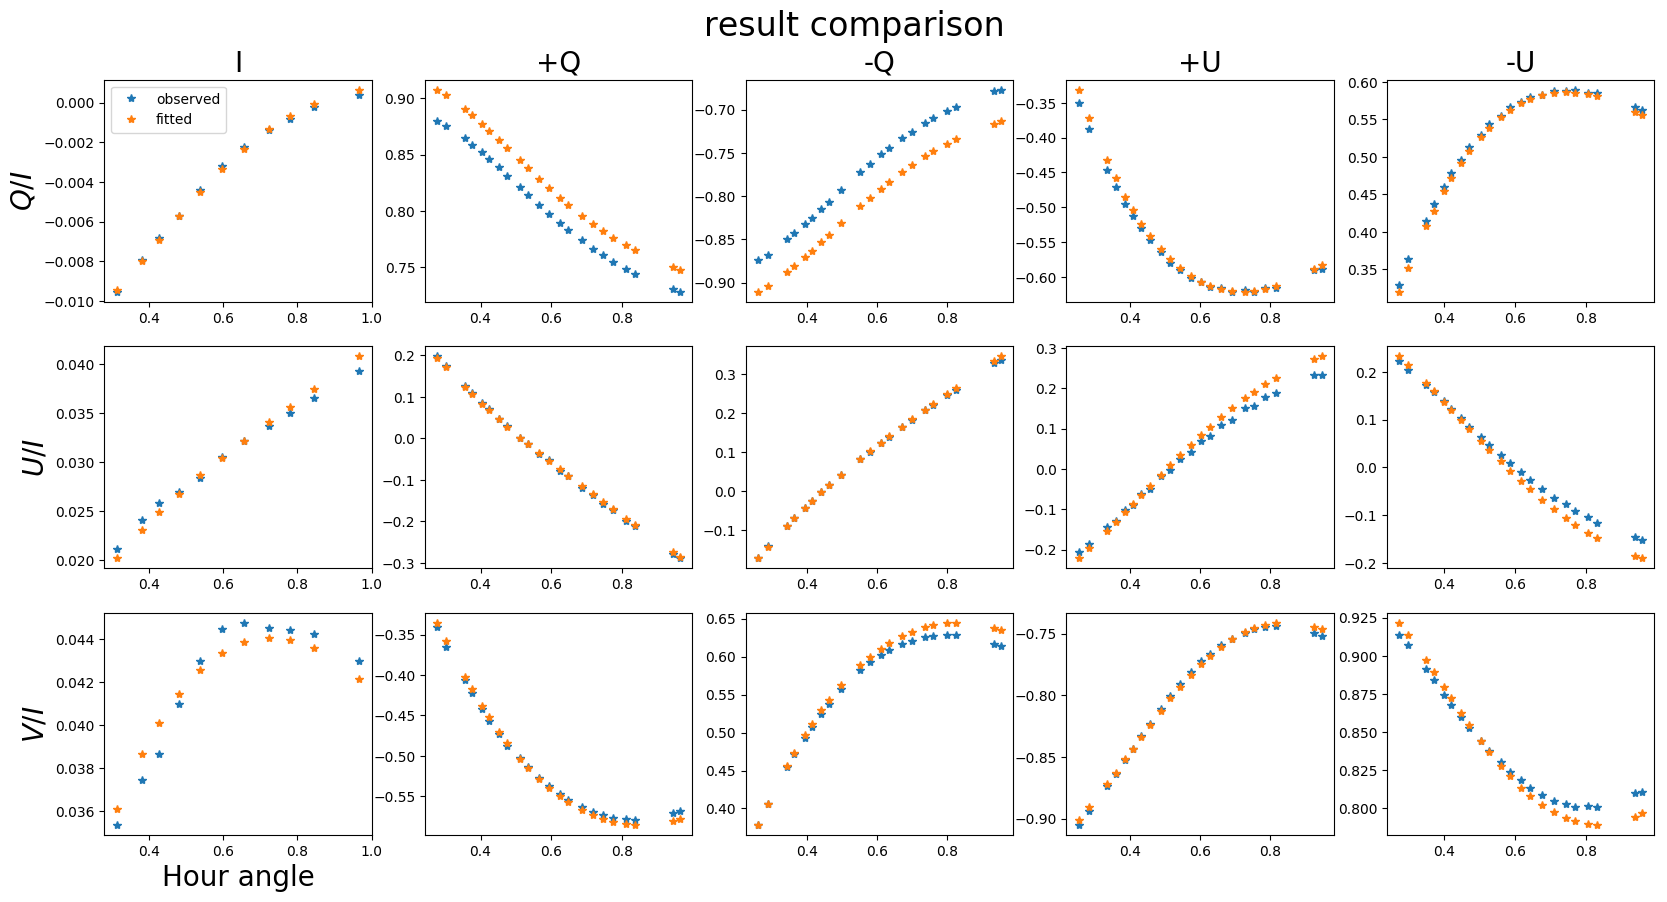

In [70]:
#
obsDict = QUVforPlot(quv, key, ha)
fitDict = QUVforPlot(quv_output, key, ha)

fig, axs = plt.subplots(3,5, figsize=(20,10), dpi=100)
FontSize = 20

for i,output in enumerate(["Q","U","V"]):
    for j,incident in enumerate(["I","+Q","-Q","+U","-U"]):
        ax = axs[i,j]
        obsdata = obsDict[j]
        fitdata = fitDict[j]
        ax.plot(obsdata["ha"], obsdata["data"][:,i], '*', markersize=6, label="observed")
        ax.plot(fitdata["ha"], fitdata["data"][:,i], '*', markersize=6, label="fitted")
        #ax.axhline(y=0, linewidth=0.7)
        
        #--- title
        if i == 0:
            ax.set_title(incident, fontsize=FontSize)
        #--- ylabel
        if j == 0:
            ax.set_ylabel("${}/I$".format(output), fontsize=FontSize)

        #--- xlabel
        if i == 2 and j == 0:
            ax.set_xlabel("Hour angle", fontsize=FontSize)

        #--- ylimit, fill_between
        #if j == 0:
            #ax.set_ylim(, )
            #ax.fill_between(ha, -0.0003,0.0003, facecolor='gray', alpha=0.3, interpolate=True)
axs[0,0].legend(loc="best")
fig.suptitle("result comparison", fontsize=24, x=0.5, y=0.95);

### plot residual of fitted model

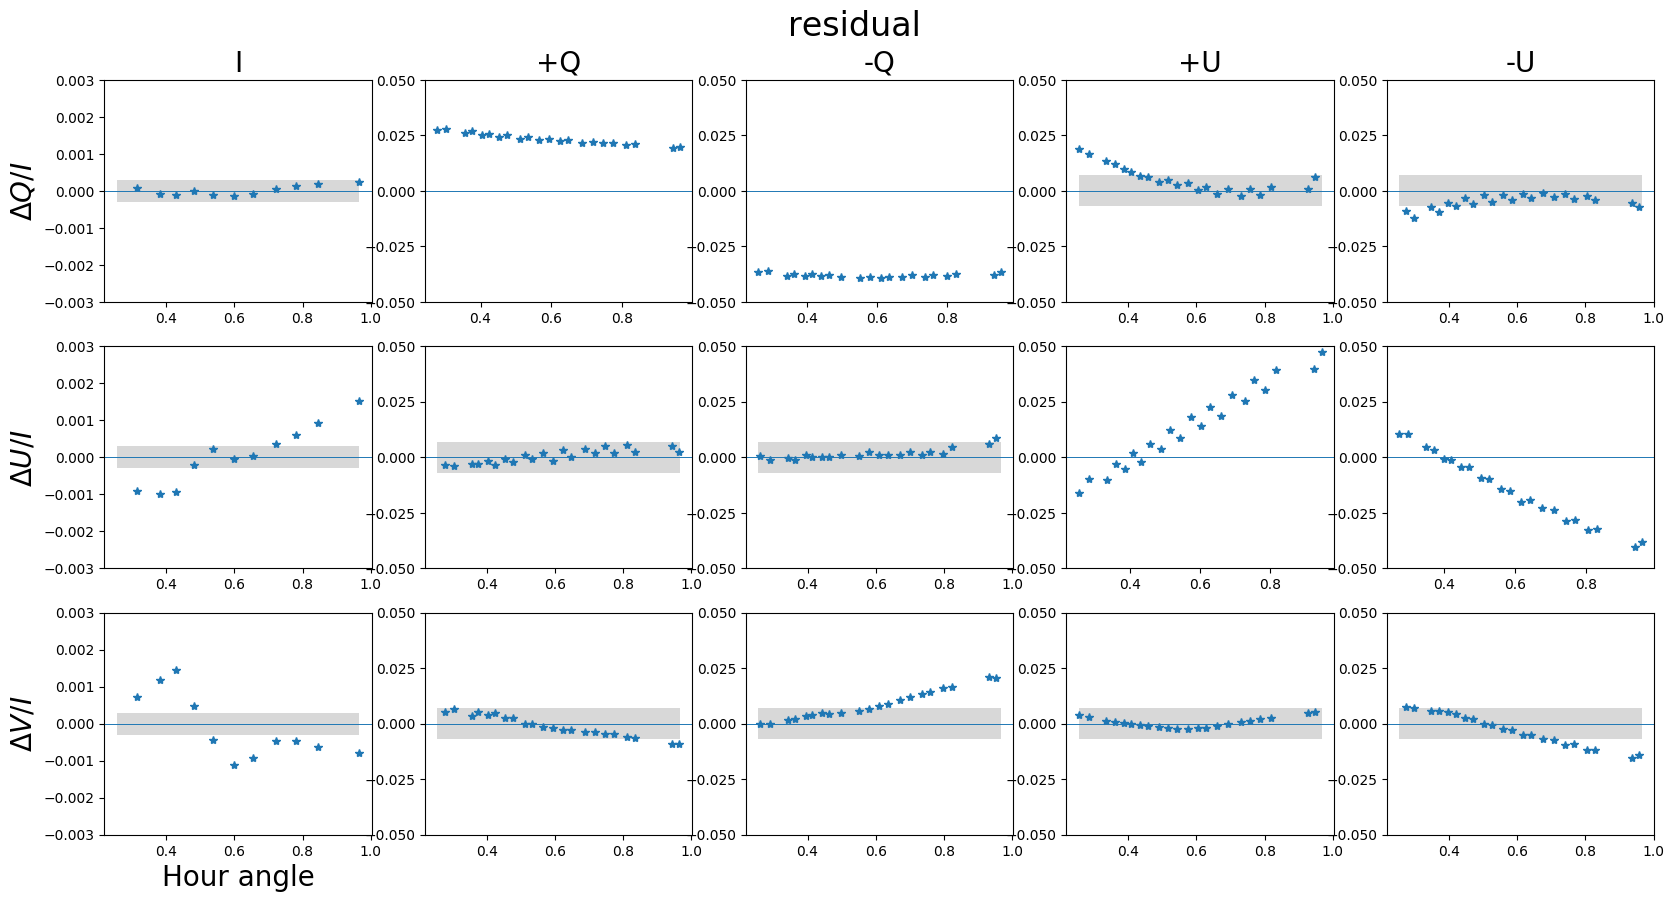

In [72]:
#
residualDict = QUVforPlot(resultMean.residual, key, ha)

fig, axs = plt.subplots(3,5, figsize=(20,10), dpi=100)
FontSize = 20

for i,output in enumerate(["Q","U","V"]):
    for j,incident in enumerate(["I","+Q","-Q","+U","-U"]):
        ax = axs[i,j]
        residualdata = residualDict[j]
        ax.plot(residualdata["ha"], residualdata["data"][:,i], '*', markersize=6)
        ax.axhline(y=0, linewidth=0.7)
        
        #--- title
        if i == 0:
            ax.set_title(incident, fontsize=FontSize)
        #--- ylabel
        if j == 0:
            ax.set_ylabel("$\Delta {}/I$".format(output), fontsize=FontSize)

        #--- xlabel
        if i == 2 and j == 0:
            ax.set_xlabel("Hour angle", fontsize=FontSize)

        #--- ylimit, fill_between
        if j == 0:
            ax.set_ylim(-0.003, +0.003)
            ax.fill_between(ha, -0.0003,0.0003, facecolor='gray', alpha=0.3, interpolate=True)
        else:
            ax.set_ylim(-0.05,+0.05)
            ax.set_yticks([-0.05, -0.025, 0, 0.025, 0.05])
for i, j in zip((0,0,1,1,2,2,2,2),(3,4,1,2,1,2,3,4)):
    ax = axs[i,j]
    ax.fill_between(ha, -0.007,0.007, facecolor='gray', alpha=0.3, interpolate=True)
    
axs[0,0].legend(loc="best")
fig.suptitle("residual", fontsize=24, x=0.5, y=0.95);

## fit mean profile with hsp as a Mueller Matrix

In [76]:
par=parameterDST(hdFit["zd"][0], wave=wave, th_mmsp2_hsp=(88.2 - 131.2)*dtor)
par["xn"].set(value=-0.0387)
par["tn"].set(value=-16.8*dtor)
par["xc"].set(value=-0.0321)
par["tc"].set(value=12.5*dtor)
for i in range(4):
    for j in range(4):
        par.add( "hsp_{}{}".format(i,j), value=1., min=-1, max=1, vary=True)
        
par["hsp_00"].set(vary=False)

In [77]:
resultMeanHSP = lmfit.minimize(residual, par, args=(quv,sigma,ha,zd,azimuth,incli,key), method='leastsq', ftol=1E-18, xtol=1E-18)
quv_outputHSP, responseMatrixMeanHSP = model(resultMeanHSP.params, ha, zd, azimuth, incli, key)
resultMeanHSP.residual = quv_outputHSP - quv

In [45]:
lmfit.report_fit(resultMeanHSP)

[[Fit Statistics]]
    # function evals   = 974
    # data points      = 294
    # variables        = 23
    chi-square         = 108.997
    reduced chi-square = 0.402
    Akaike info crit   = -245.725
    Bayesian info crit = -161.003
[[Variables]]
    xn:            -0.04580299 +/- 0        (0.00%) (init=-0.0387)
    tn:            -0.22250083 +/- 0        (0.00%) (init=-0.2932153)
    xc:            -0.00135377 +/- 0        (0.00%) (init=-0.0321)
    tc:             0.53429802 +/- 0        (0.00%) (init= 0.2181662)
    sc:             0          +/- 0        (nan%) (init= 0)
    t_en:           0 (fixed)
    dlen:           0 (fixed)
    t_ex:           0 (fixed)
    dlex:           0 (fixed)
    th_dst_mmsp2:   0          +/- 0        (nan%) (init= 0)
    th_mmsp2_hsp:  -0.75049157 +/- 0        (0.00%) (init=-0.7504916)
    th_calunit:     0.03321617 +/- 0        (0.00%) (init= 0)
    hsp_00:         1 (fixed)
    hsp_01:        -0.03454526 +/- 0        (0.00%) (init= 1)
    hsp_0

### plot quv output of fitted model

default with `ftol=1E-7, xtol=1E-7` failed.

scaled sigma with `ftol=1E-10, xtol=1E-10`.

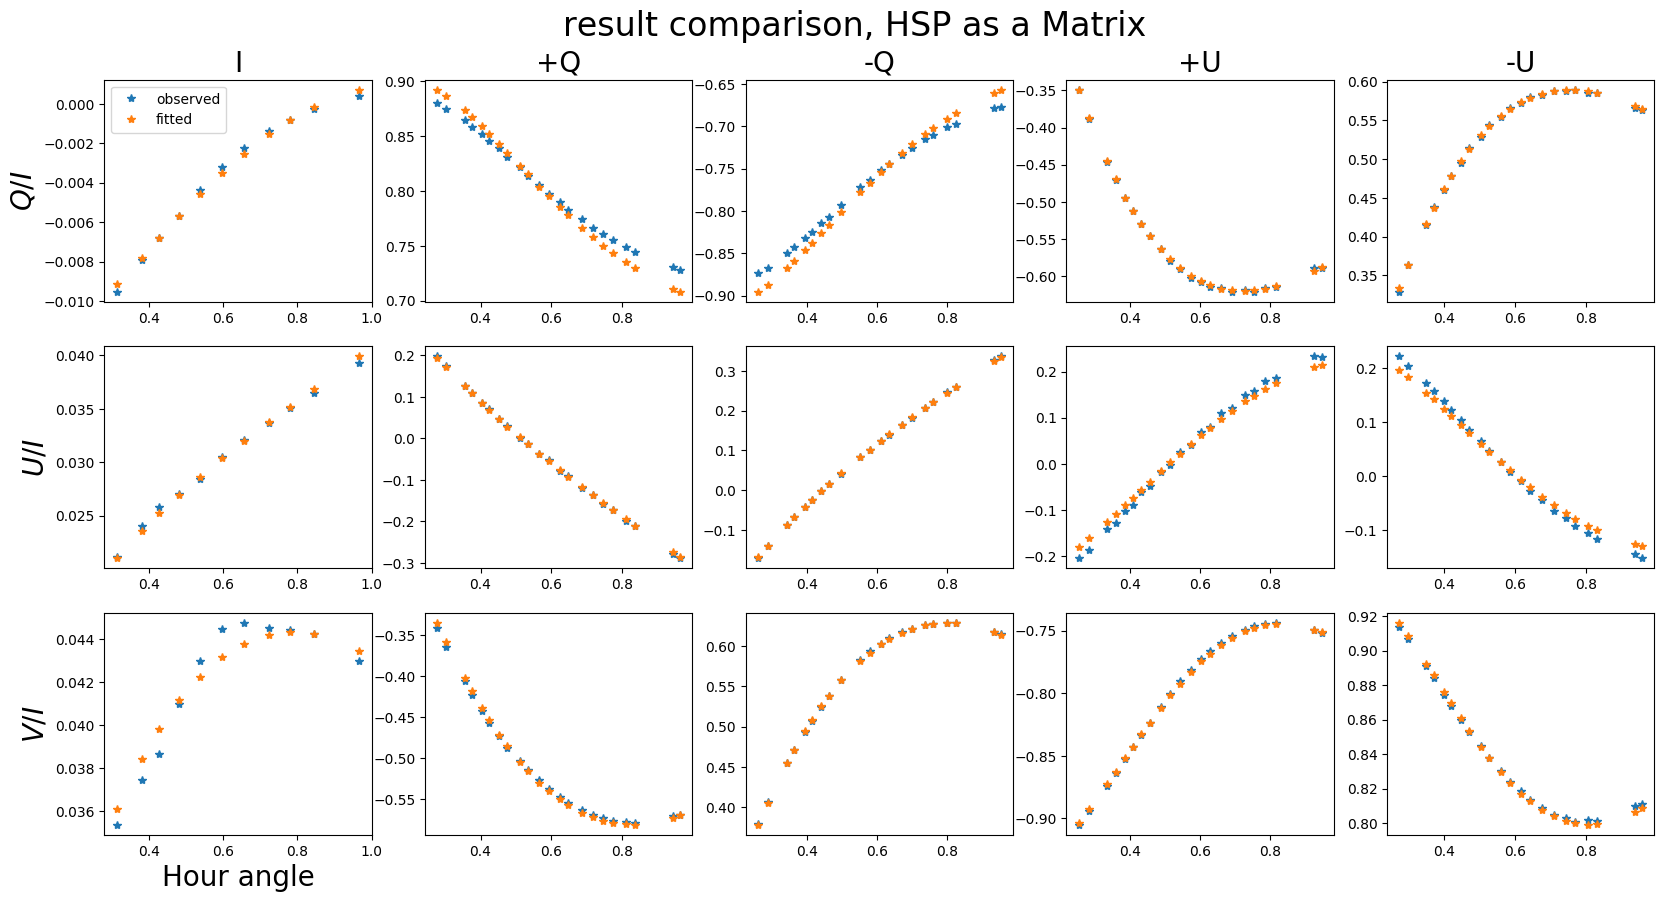

In [46]:
#
obsDict = QUVforPlot(quv, key, ha)
fitDict = QUVforPlot(quv_outputHSP, key, ha)

fig, axs = plt.subplots(3,5, figsize=(20,10), dpi=100)
FontSize = 20

for i,output in enumerate(["Q","U","V"]):
    for j,incident in enumerate(["I","+Q","-Q","+U","-U"]):
        ax = axs[i,j]
        obsdata = obsDict[j]
        fitdata = fitDict[j]
        ax.plot(obsdata["ha"], obsdata["data"][:,i], '*', markersize=6, label="observed")
        ax.plot(fitdata["ha"], fitdata["data"][:,i], '*', markersize=6, label="fitted")
        #ax.axhline(y=0, linewidth=0.7)
        
        #--- title
        if i == 0:
            ax.set_title(incident, fontsize=FontSize)
        #--- ylabel
        if j == 0:
            ax.set_ylabel("${}/I$".format(output), fontsize=FontSize)

        #--- xlabel
        if i == 2 and j == 0:
            ax.set_xlabel("Hour angle", fontsize=FontSize)

        #--- ylimit, fill_between
        #if j == 0:
            #ax.set_ylim(, )
            #ax.fill_between(ha, -0.0003,0.0003, facecolor='gray', alpha=0.3, interpolate=True)
axs[0,0].legend(loc="best")
fig.suptitle("result comparison, HSP as a Matrix", fontsize=24, x=0.5, y=0.95);

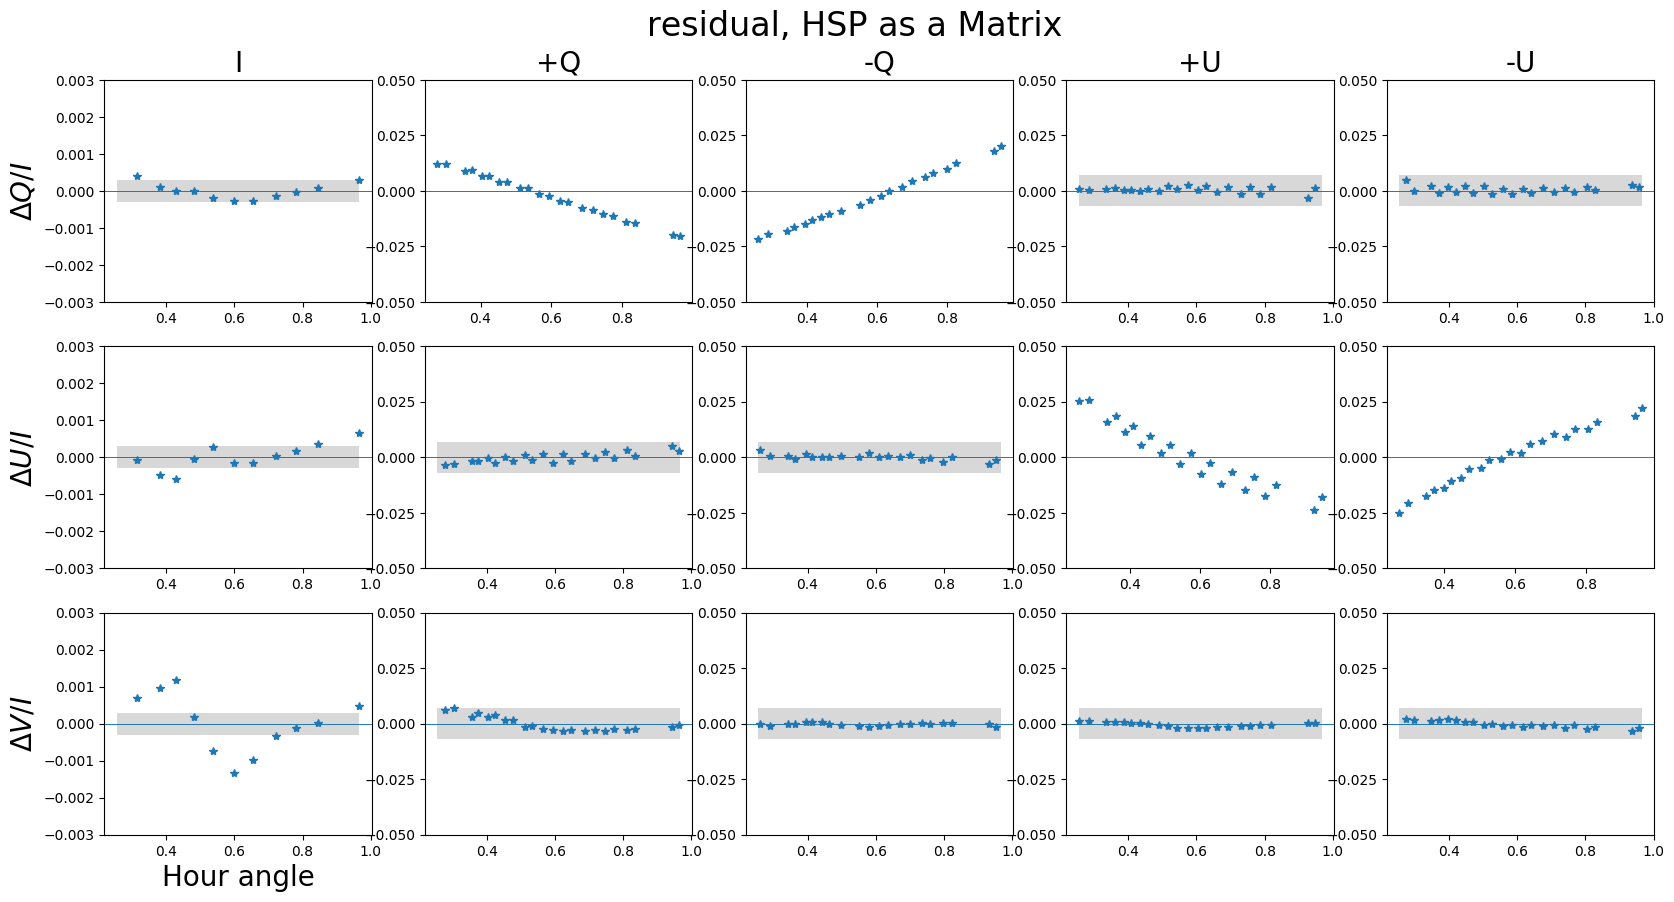

In [47]:
#
residualDict = QUVforPlot(resultMeanHSP.residual, key, ha)

fig, axs = plt.subplots(3,5, figsize=(20,10), dpi=100)
FontSize = 20

for i,output in enumerate(["Q","U","V"]):
    for j,incident in enumerate(["I","+Q","-Q","+U","-U"]):
        ax = axs[i,j]
        residualdata = residualDict[j]
        ax.plot(residualdata["ha"], residualdata["data"][:,i], '*', markersize=6)
        ax.axhline(y=0, linewidth=0.7)
        
        #--- title
        if i == 0:
            ax.set_title(incident, fontsize=FontSize)
        #--- ylabel
        if j == 0:
            ax.set_ylabel("$\Delta {}/I$".format(output), fontsize=FontSize)

        #--- xlabel
        if i == 2 and j == 0:
            ax.set_xlabel("Hour angle", fontsize=FontSize)

        #--- ylimit, fill_between
        if j == 0:
            ax.set_ylim(-0.003, +0.003)
            ax.fill_between(ha, -0.0003,0.0003, facecolor='gray', alpha=0.3, interpolate=True)
        else:
            ax.set_ylim(-0.05,+0.05)
            ax.set_yticks([-0.05, -0.025, 0, 0.025, 0.05])
for i, j in zip((0,0,1,1,2,2,2,2),(3,4,1,2,1,2,3,4)):
    ax = axs[i,j]
    ax.fill_between(ha, -0.007,0.007, facecolor='gray', alpha=0.3, interpolate=True)
axs[0,0].legend(loc="best")
fig.suptitle("residual, HSP as a Matrix", fontsize=24, x=0.5, y=0.95);

scaled sigma with `ftol=1E-12, xtol=1E-12`.

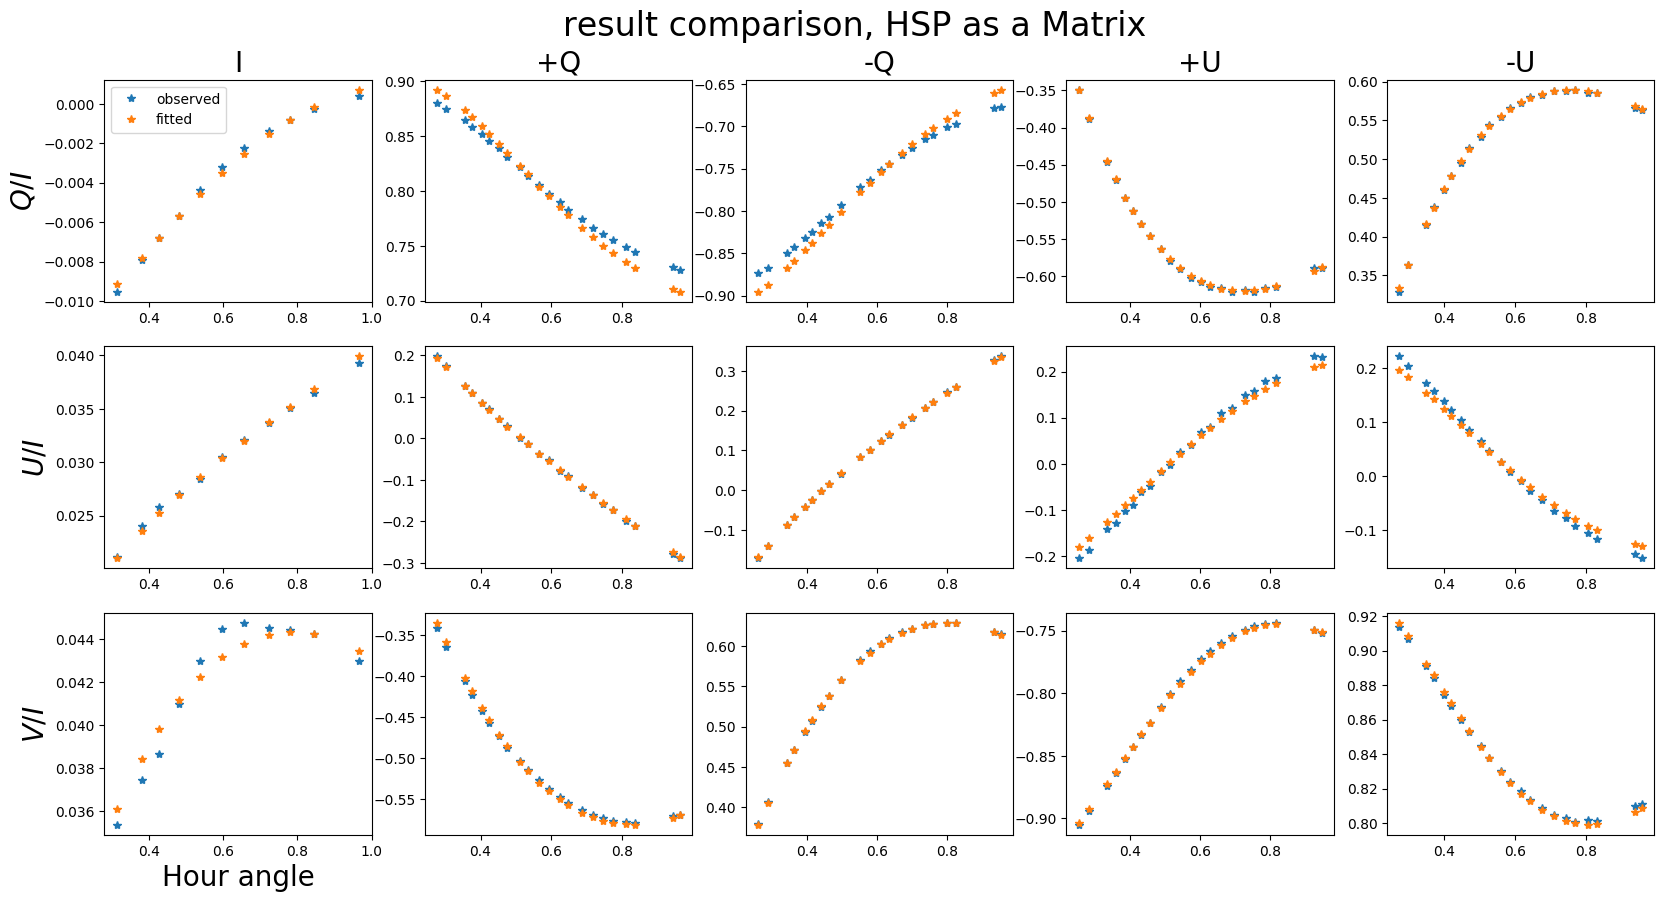

In [50]:
#
obsDict = QUVforPlot(quv, key, ha)
fitDict = QUVforPlot(quv_outputHSP, key, ha)

fig, axs = plt.subplots(3,5, figsize=(20,10), dpi=100)
FontSize = 20

for i,output in enumerate(["Q","U","V"]):
    for j,incident in enumerate(["I","+Q","-Q","+U","-U"]):
        ax = axs[i,j]
        obsdata = obsDict[j]
        fitdata = fitDict[j]
        ax.plot(obsdata["ha"], obsdata["data"][:,i], '*', markersize=6, label="observed")
        ax.plot(fitdata["ha"], fitdata["data"][:,i], '*', markersize=6, label="fitted")
        #ax.axhline(y=0, linewidth=0.7)
        
        #--- title
        if i == 0:
            ax.set_title(incident, fontsize=FontSize)
        #--- ylabel
        if j == 0:
            ax.set_ylabel("${}/I$".format(output), fontsize=FontSize)

        #--- xlabel
        if i == 2 and j == 0:
            ax.set_xlabel("Hour angle", fontsize=FontSize)

        #--- ylimit, fill_between
        #if j == 0:
            #ax.set_ylim(, )
            #ax.fill_between(ha, -0.0003,0.0003, facecolor='gray', alpha=0.3, interpolate=True)
axs[0,0].legend(loc="best")
fig.suptitle("result comparison, HSP as a Matrix", fontsize=24, x=0.5, y=0.95);

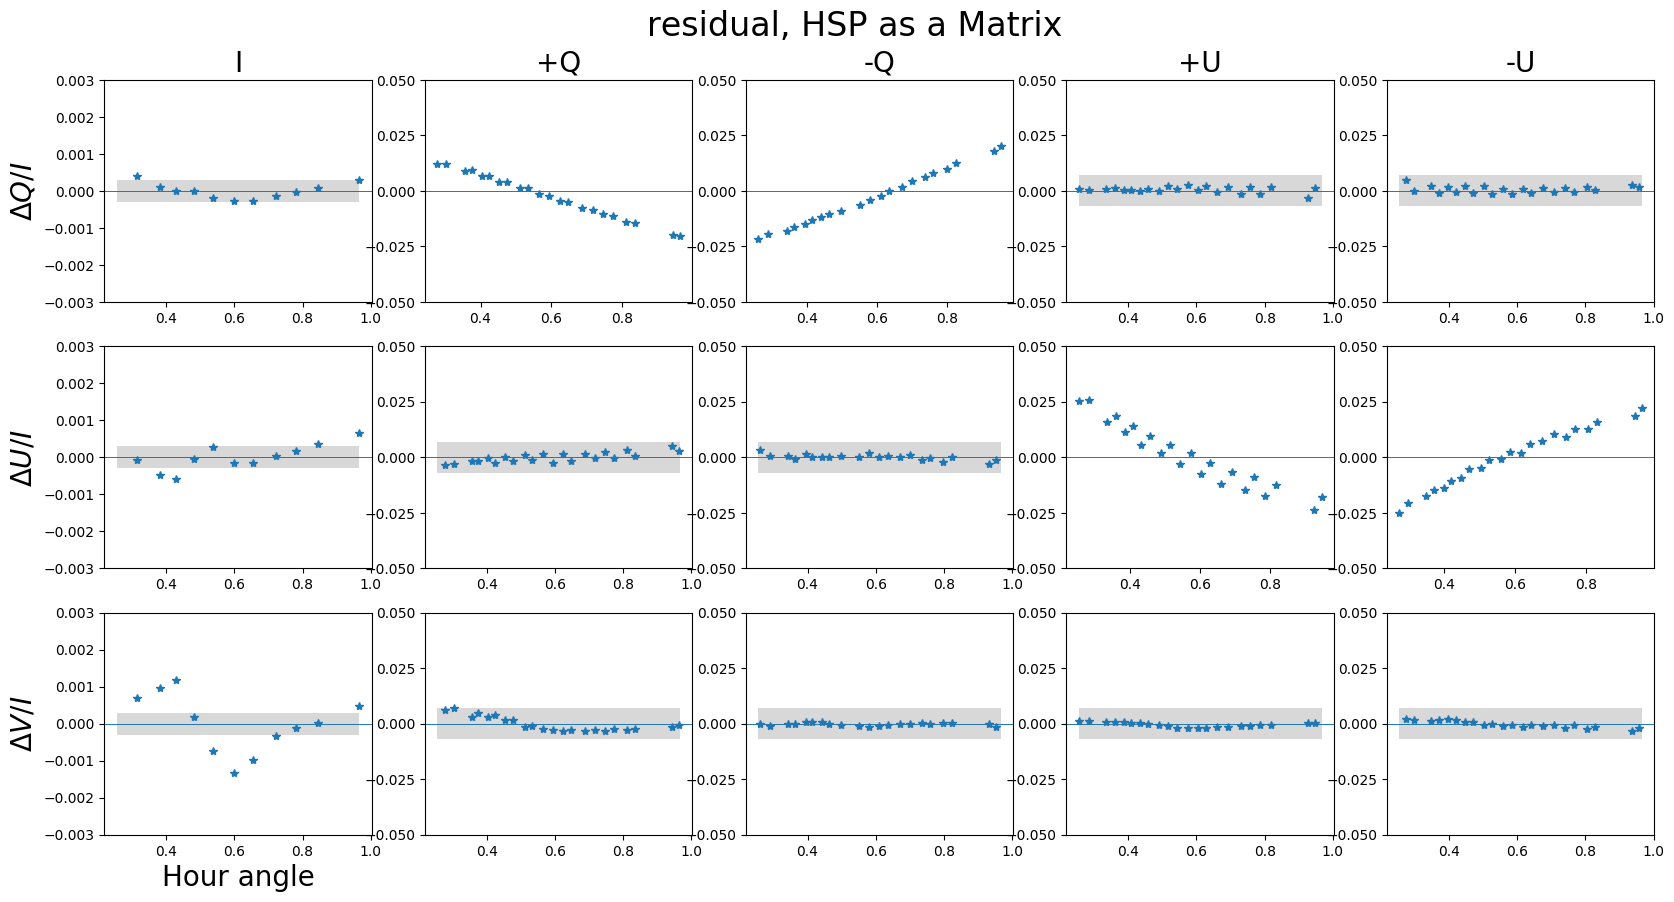

In [51]:
#
residualDict = QUVforPlot(resultMeanHSP.residual, key, ha)

fig, axs = plt.subplots(3,5, figsize=(20,10), dpi=100)
FontSize = 20

for i,output in enumerate(["Q","U","V"]):
    for j,incident in enumerate(["I","+Q","-Q","+U","-U"]):
        ax = axs[i,j]
        residualdata = residualDict[j]
        ax.plot(residualdata["ha"], residualdata["data"][:,i], '*', markersize=6)
        ax.axhline(y=0, linewidth=0.7)
        
        #--- title
        if i == 0:
            ax.set_title(incident, fontsize=FontSize)
        #--- ylabel
        if j == 0:
            ax.set_ylabel("$\Delta {}/I$".format(output), fontsize=FontSize)

        #--- xlabel
        if i == 2 and j == 0:
            ax.set_xlabel("Hour angle", fontsize=FontSize)

        #--- ylimit, fill_between
        if j == 0:
            ax.set_ylim(-0.003, +0.003)
            ax.fill_between(ha, -0.0003,0.0003, facecolor='gray', alpha=0.3, interpolate=True)
        else:
            ax.set_ylim(-0.05,+0.05)
            ax.set_yticks([-0.05, -0.025, 0, 0.025, 0.05])
for i, j in zip((0,0,1,1,2,2,2,2),(3,4,1,2,1,2,3,4)):
    ax = axs[i,j]
    ax.fill_between(ha, -0.007,0.007, facecolor='gray', alpha=0.3, interpolate=True)
axs[0,0].legend(loc="best")
fig.suptitle("residual, HSP as a Matrix", fontsize=24, x=0.5, y=0.95);

scaled sigma with `ftol=1E-18, xtol=1E-18`.

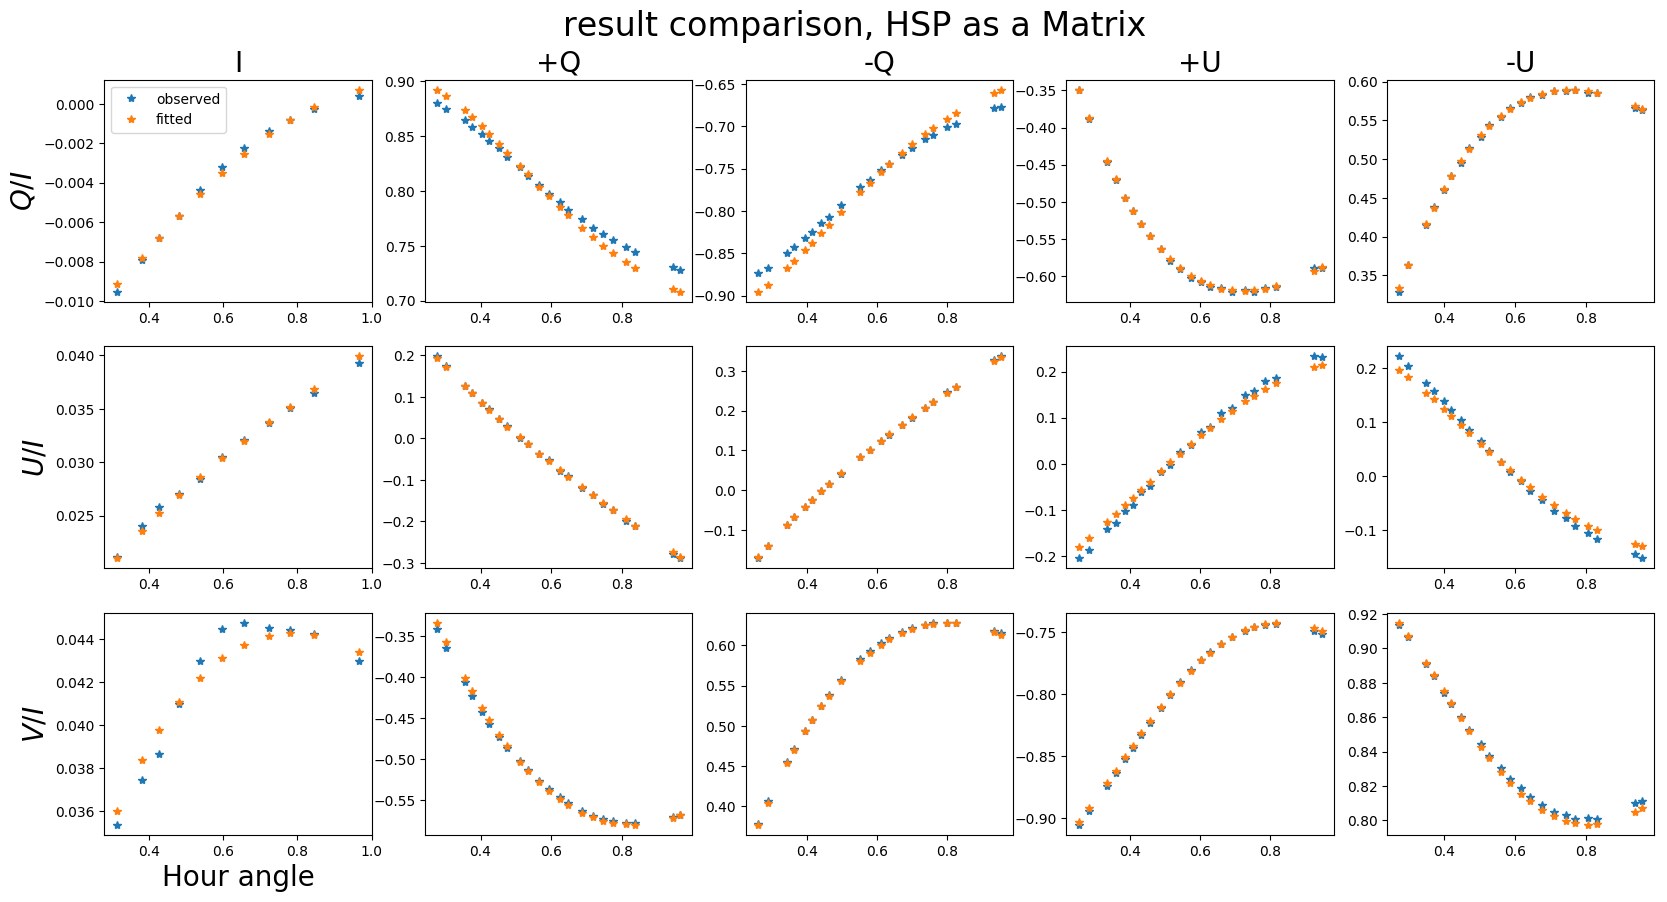

In [63]:
#
obsDict = QUVforPlot(quv, key, ha)
fitDict = QUVforPlot(quv_outputHSP, key, ha)

fig, axs = plt.subplots(3,5, figsize=(20,10), dpi=100)
FontSize = 20

for i,output in enumerate(["Q","U","V"]):
    for j,incident in enumerate(["I","+Q","-Q","+U","-U"]):
        ax = axs[i,j]
        obsdata = obsDict[j]
        fitdata = fitDict[j]
        ax.plot(obsdata["ha"], obsdata["data"][:,i], '*', markersize=6, label="observed")
        ax.plot(fitdata["ha"], fitdata["data"][:,i], '*', markersize=6, label="fitted")
        #ax.axhline(y=0, linewidth=0.7)
        
        #--- title
        if i == 0:
            ax.set_title(incident, fontsize=FontSize)
        #--- ylabel
        if j == 0:
            ax.set_ylabel("${}/I$".format(output), fontsize=FontSize)

        #--- xlabel
        if i == 2 and j == 0:
            ax.set_xlabel("Hour angle", fontsize=FontSize)

        #--- ylimit, fill_between
        #if j == 0:
            #ax.set_ylim(, )
            #ax.fill_between(ha, -0.0003,0.0003, facecolor='gray', alpha=0.3, interpolate=True)
axs[0,0].legend(loc="best")
fig.suptitle("result comparison, HSP as a Matrix", fontsize=24, x=0.5, y=0.95);

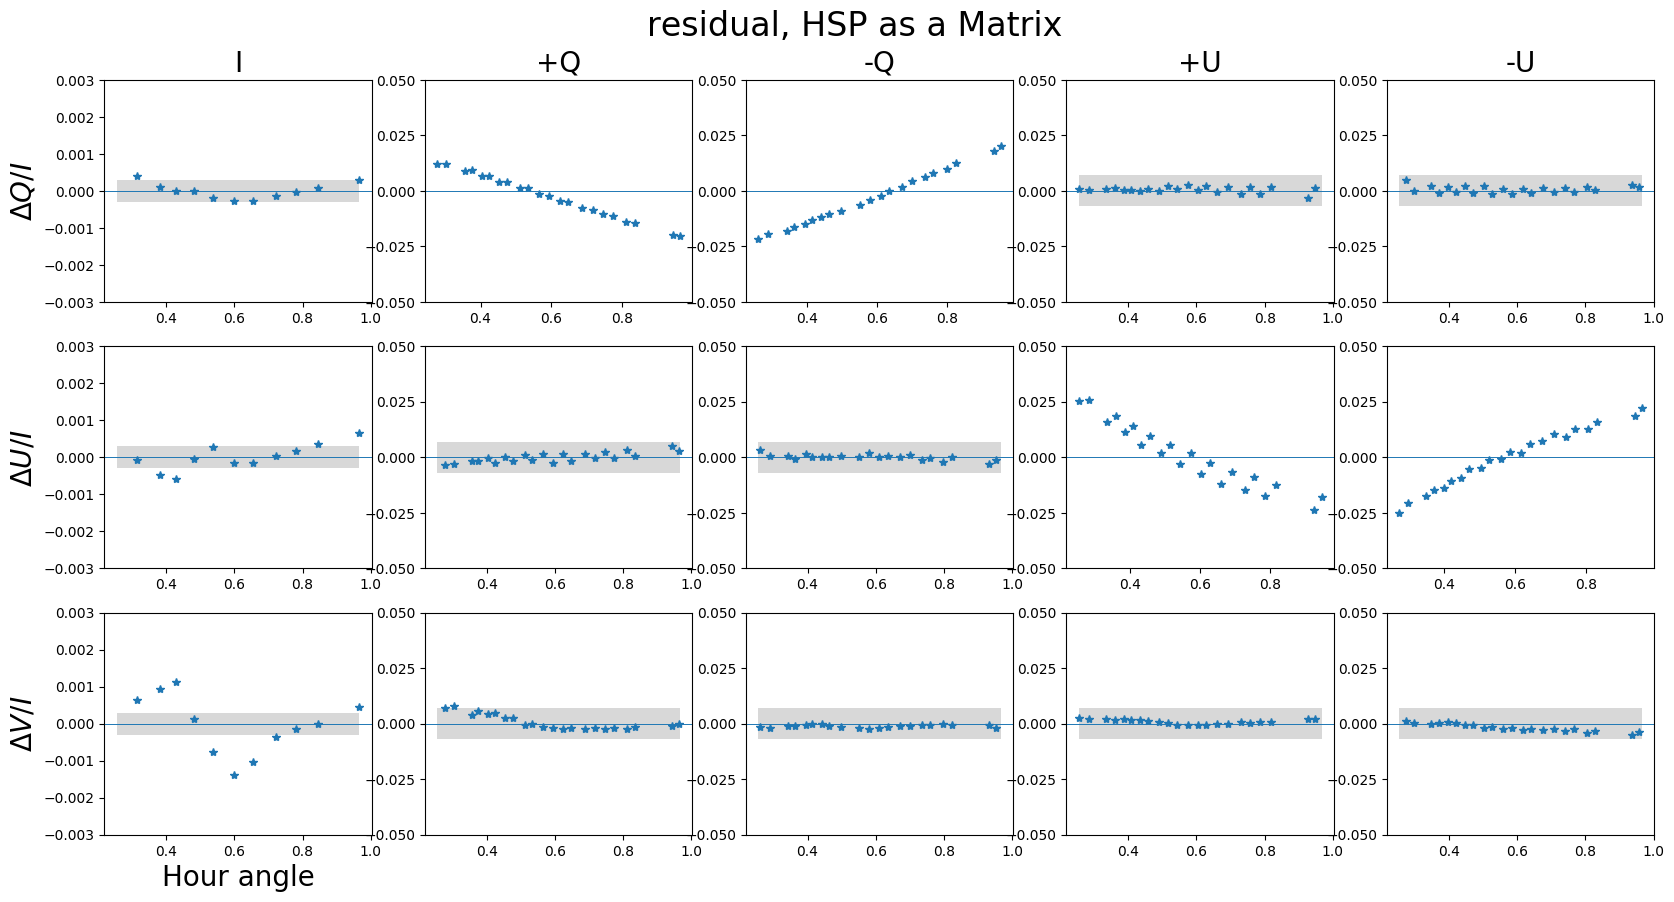

In [64]:
#
residualDict = QUVforPlot(resultMeanHSP.residual, key, ha)

fig, axs = plt.subplots(3,5, figsize=(20,10), dpi=100)
FontSize = 20

for i,output in enumerate(["Q","U","V"]):
    for j,incident in enumerate(["I","+Q","-Q","+U","-U"]):
        ax = axs[i,j]
        residualdata = residualDict[j]
        ax.plot(residualdata["ha"], residualdata["data"][:,i], '*', markersize=6)
        ax.axhline(y=0, linewidth=0.7)
        
        #--- title
        if i == 0:
            ax.set_title(incident, fontsize=FontSize)
        #--- ylabel
        if j == 0:
            ax.set_ylabel("$\Delta {}/I$".format(output), fontsize=FontSize)

        #--- xlabel
        if i == 2 and j == 0:
            ax.set_xlabel("Hour angle", fontsize=FontSize)

        #--- ylimit, fill_between
        if j == 0:
            ax.set_ylim(-0.003, +0.003)
            ax.fill_between(ha, -0.0003,0.0003, facecolor='gray', alpha=0.3, interpolate=True)
        else:
            ax.set_ylim(-0.05,+0.05)
            ax.set_yticks([-0.05, -0.025, 0, 0.025, 0.05])
for i, j in zip((0,0,1,1,2,2,2,2),(3,4,1,2,1,2,3,4)):
    ax = axs[i,j]
    ax.fill_between(ha, -0.007,0.007, facecolor='gray', alpha=0.3, interpolate=True)
axs[0,0].legend(loc="best")
fig.suptitle("residual, HSP as a Matrix", fontsize=24, x=0.5, y=0.95);

uniform sigma with `ftol=1E-12, xtol=1E-12`

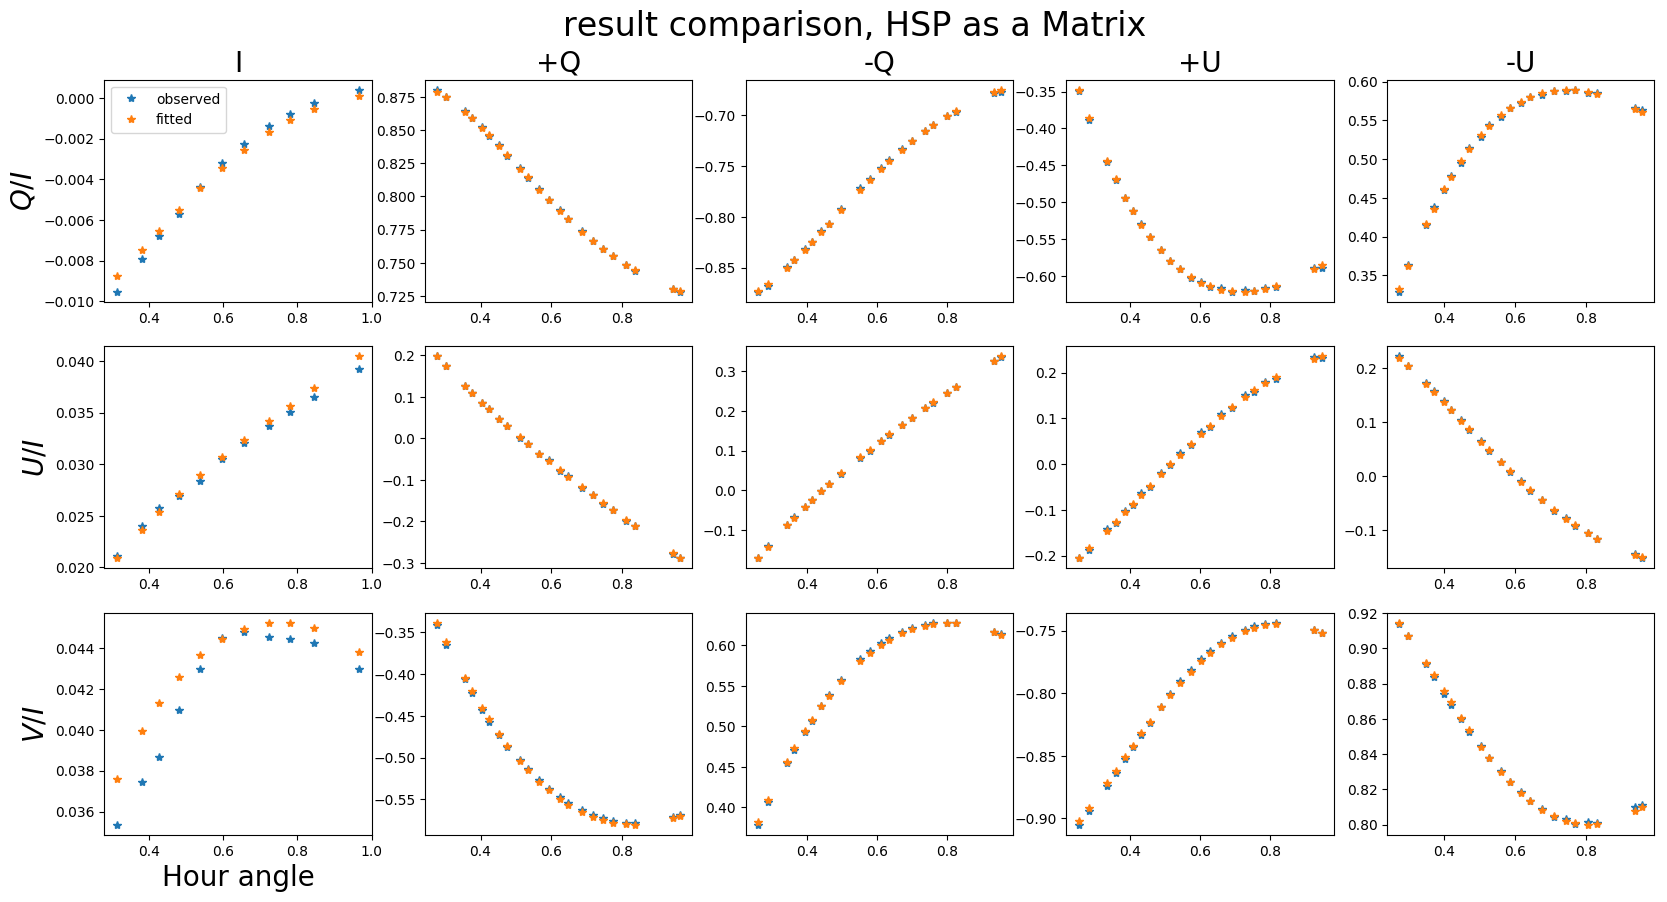

In [55]:
#
obsDict = QUVforPlot(quv, key, ha)
fitDict = QUVforPlot(quv_outputHSP, key, ha)

fig, axs = plt.subplots(3,5, figsize=(20,10), dpi=100)
FontSize = 20

for i,output in enumerate(["Q","U","V"]):
    for j,incident in enumerate(["I","+Q","-Q","+U","-U"]):
        ax = axs[i,j]
        obsdata = obsDict[j]
        fitdata = fitDict[j]
        ax.plot(obsdata["ha"], obsdata["data"][:,i], '*', markersize=6, label="observed")
        ax.plot(fitdata["ha"], fitdata["data"][:,i], '*', markersize=6, label="fitted")
        #ax.axhline(y=0, linewidth=0.7)
        
        #--- title
        if i == 0:
            ax.set_title(incident, fontsize=FontSize)
        #--- ylabel
        if j == 0:
            ax.set_ylabel("${}/I$".format(output), fontsize=FontSize)

        #--- xlabel
        if i == 2 and j == 0:
            ax.set_xlabel("Hour angle", fontsize=FontSize)

        #--- ylimit, fill_between
        #if j == 0:
            #ax.set_ylim(, )
            #ax.fill_between(ha, -0.0003,0.0003, facecolor='gray', alpha=0.3, interpolate=True)
axs[0,0].legend(loc="best")
fig.suptitle("result comparison, HSP as a Matrix", fontsize=24, x=0.5, y=0.95);

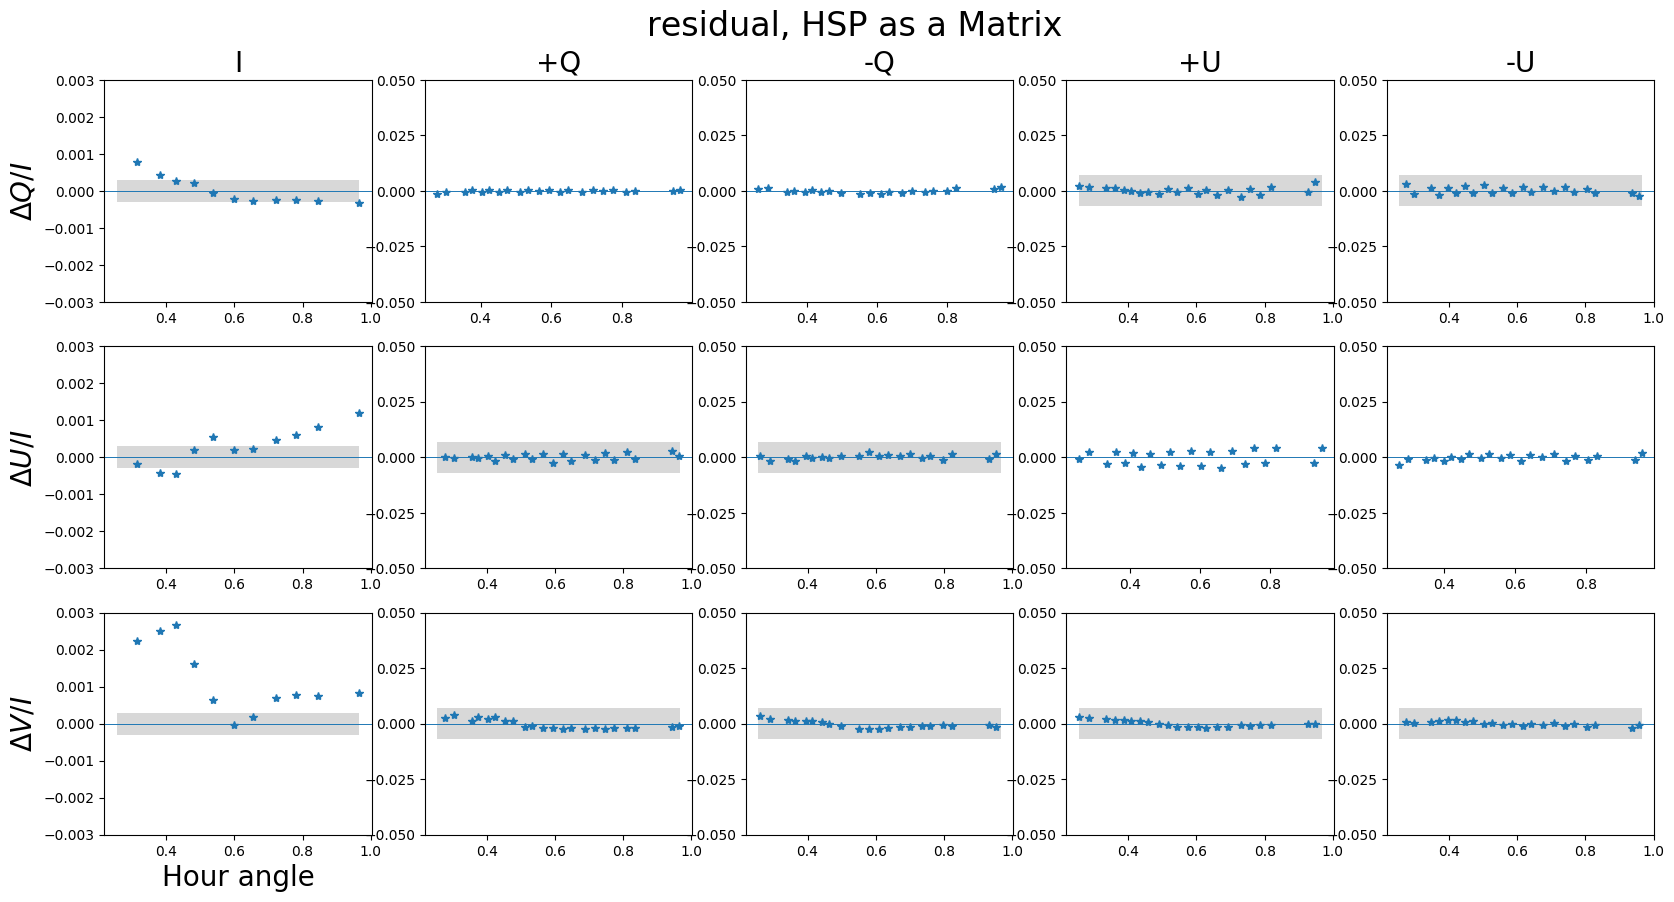

In [56]:
#
residualDict = QUVforPlot(resultMeanHSP.residual, key, ha)

fig, axs = plt.subplots(3,5, figsize=(20,10), dpi=100)
FontSize = 20

for i,output in enumerate(["Q","U","V"]):
    for j,incident in enumerate(["I","+Q","-Q","+U","-U"]):
        ax = axs[i,j]
        residualdata = residualDict[j]
        ax.plot(residualdata["ha"], residualdata["data"][:,i], '*', markersize=6)
        ax.axhline(y=0, linewidth=0.7)
        
        #--- title
        if i == 0:
            ax.set_title(incident, fontsize=FontSize)
        #--- ylabel
        if j == 0:
            ax.set_ylabel("$\Delta {}/I$".format(output), fontsize=FontSize)

        #--- xlabel
        if i == 2 and j == 0:
            ax.set_xlabel("Hour angle", fontsize=FontSize)

        #--- ylimit, fill_between
        if j == 0:
            ax.set_ylim(-0.003, +0.003)
            ax.fill_between(ha, -0.0003,0.0003, facecolor='gray', alpha=0.3, interpolate=True)
        else:
            ax.set_ylim(-0.05,+0.05)
            ax.set_yticks([-0.05, -0.025, 0, 0.025, 0.05])
for i, j in zip((0,0,1,1,2,2,2,2),(3,4,1,2,1,2,3,4)):
    ax = axs[i,j]
    ax.fill_between(ha, -0.007,0.007, facecolor='gray', alpha=0.3, interpolate=True)
axs[0,0].legend(loc="best")
fig.suptitle("residual, HSP as a Matrix", fontsize=24, x=0.5, y=0.95);

uniform sigma with `ftol=1E-18, xtol=1E-18`

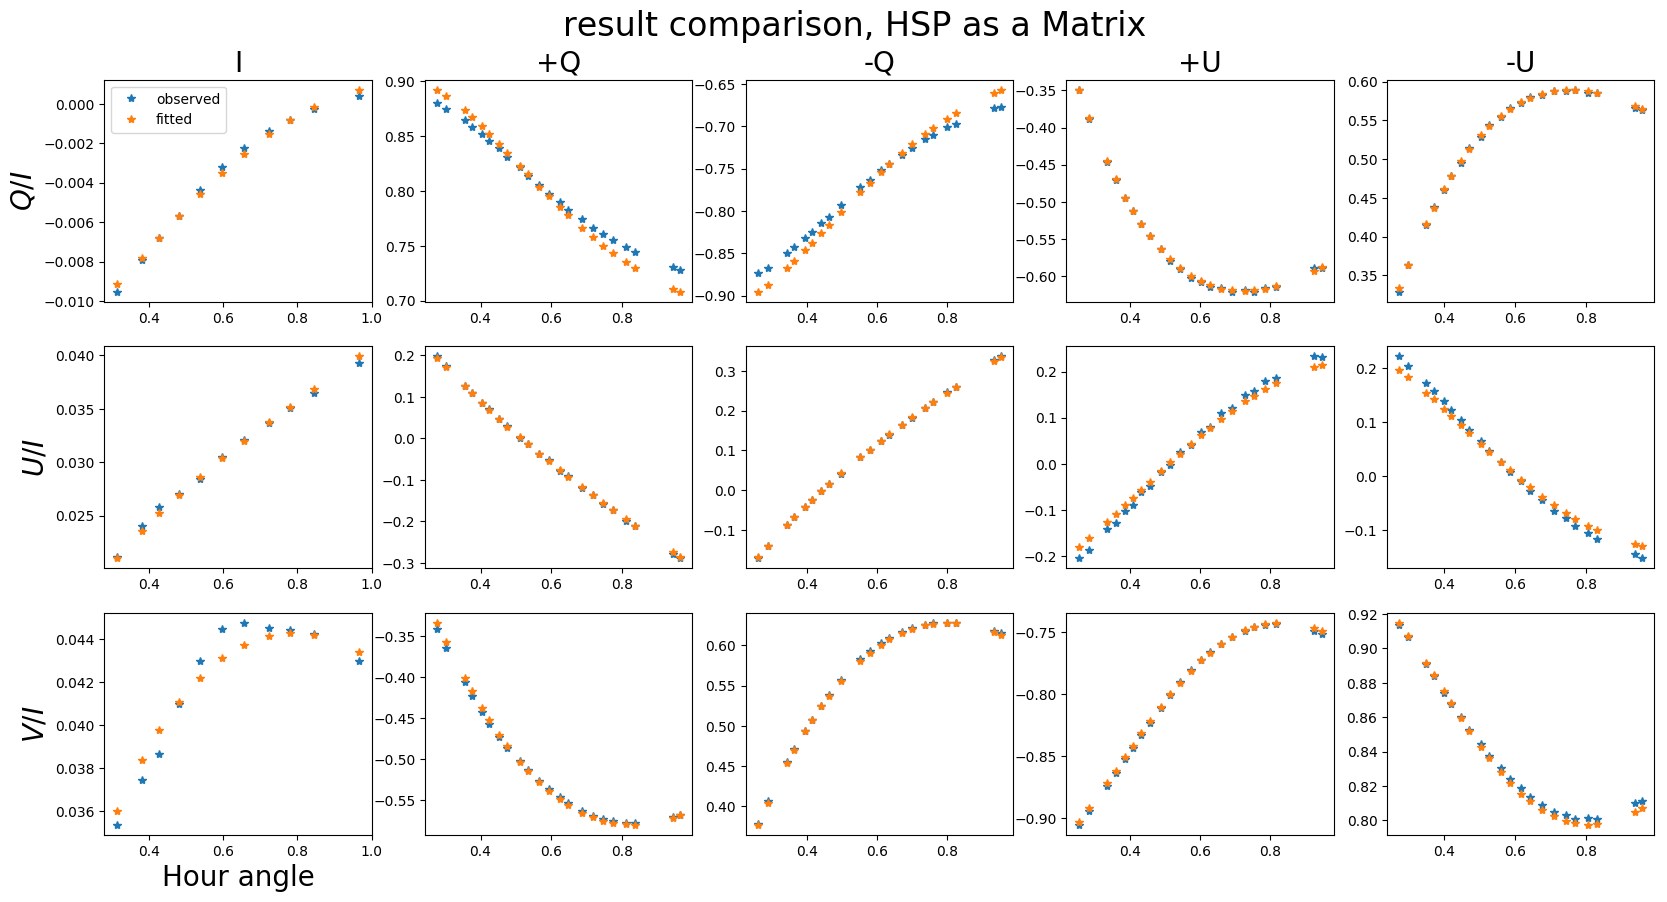

In [78]:
#
obsDict = QUVforPlot(quv, key, ha)
fitDict = QUVforPlot(quv_outputHSP, key, ha)

fig, axs = plt.subplots(3,5, figsize=(20,10), dpi=100)
FontSize = 20

for i,output in enumerate(["Q","U","V"]):
    for j,incident in enumerate(["I","+Q","-Q","+U","-U"]):
        ax = axs[i,j]
        obsdata = obsDict[j]
        fitdata = fitDict[j]
        ax.plot(obsdata["ha"], obsdata["data"][:,i], '*', markersize=6, label="observed")
        ax.plot(fitdata["ha"], fitdata["data"][:,i], '*', markersize=6, label="fitted")
        #ax.axhline(y=0, linewidth=0.7)
        
        #--- title
        if i == 0:
            ax.set_title(incident, fontsize=FontSize)
        #--- ylabel
        if j == 0:
            ax.set_ylabel("${}/I$".format(output), fontsize=FontSize)

        #--- xlabel
        if i == 2 and j == 0:
            ax.set_xlabel("Hour angle", fontsize=FontSize)

        #--- ylimit, fill_between
        #if j == 0:
            #ax.set_ylim(, )
            #ax.fill_between(ha, -0.0003,0.0003, facecolor='gray', alpha=0.3, interpolate=True)
axs[0,0].legend(loc="best")
fig.suptitle("result comparison, HSP as a Matrix", fontsize=24, x=0.5, y=0.95);

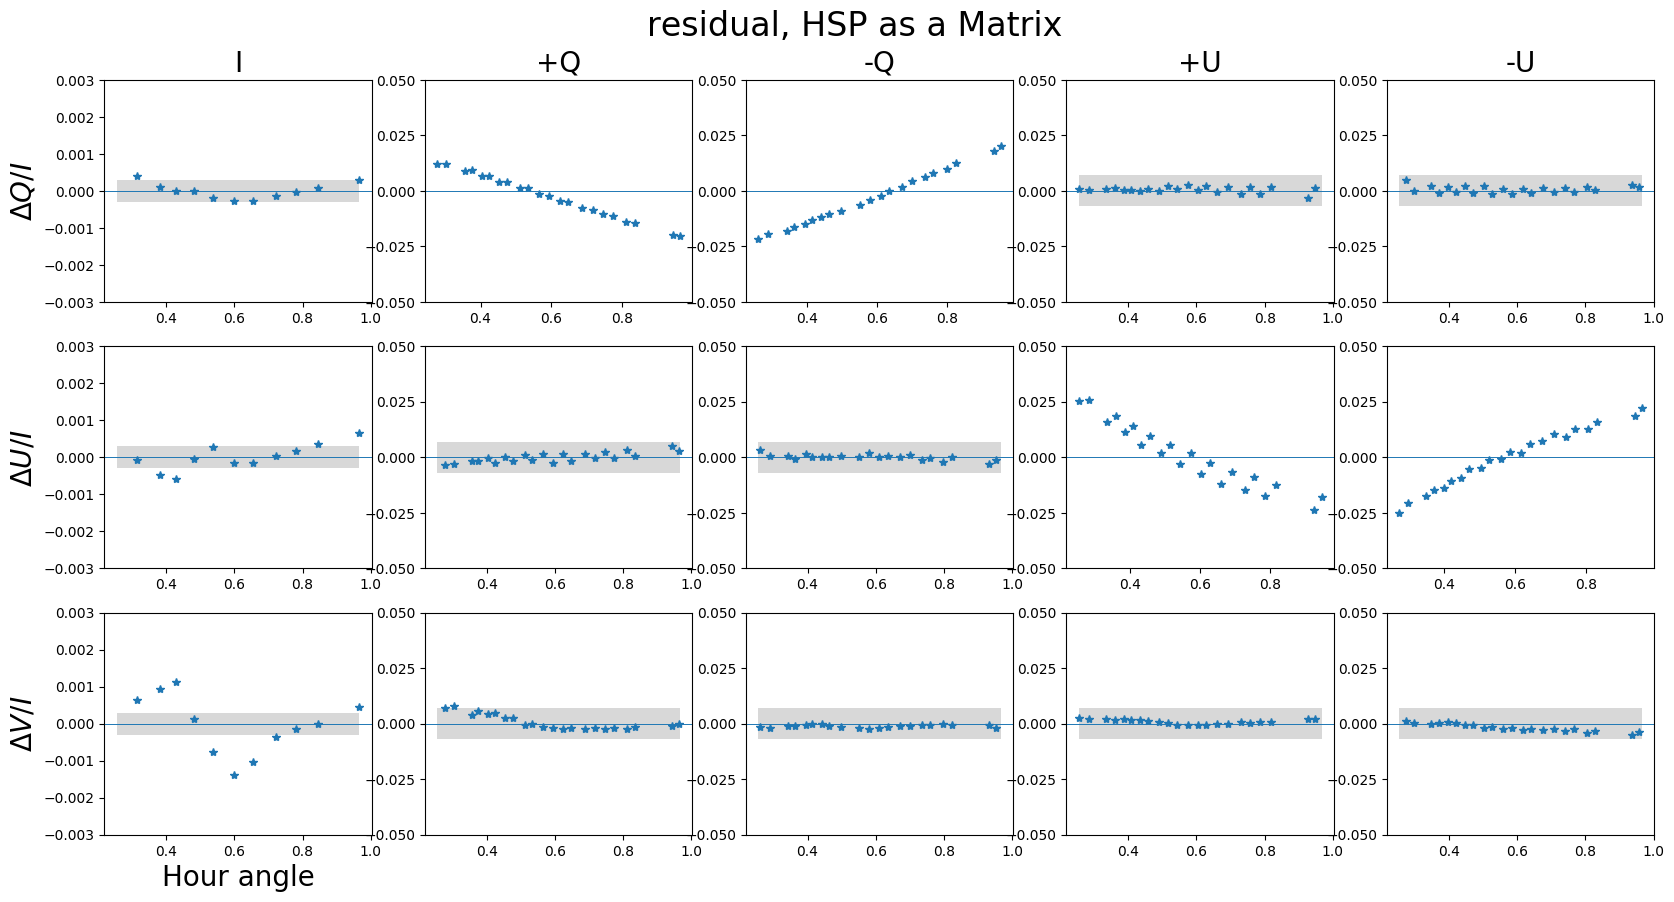

In [79]:
#
residualDict = QUVforPlot(resultMeanHSP.residual, key, ha)

fig, axs = plt.subplots(3,5, figsize=(20,10), dpi=100)
FontSize = 20

for i,output in enumerate(["Q","U","V"]):
    for j,incident in enumerate(["I","+Q","-Q","+U","-U"]):
        ax = axs[i,j]
        residualdata = residualDict[j]
        ax.plot(residualdata["ha"], residualdata["data"][:,i], '*', markersize=6)
        ax.axhline(y=0, linewidth=0.7)
        
        #--- title
        if i == 0:
            ax.set_title(incident, fontsize=FontSize)
        #--- ylabel
        if j == 0:
            ax.set_ylabel("$\Delta {}/I$".format(output), fontsize=FontSize)

        #--- xlabel
        if i == 2 and j == 0:
            ax.set_xlabel("Hour angle", fontsize=FontSize)

        #--- ylimit, fill_between
        if j == 0:
            ax.set_ylim(-0.003, +0.003)
            ax.fill_between(ha, -0.0003,0.0003, facecolor='gray', alpha=0.3, interpolate=True)
        else:
            ax.set_ylim(-0.05,+0.05)
            ax.set_yticks([-0.05, -0.025, 0, 0.025, 0.05])
for i, j in zip((0,0,1,1,2,2,2,2),(3,4,1,2,1,2,3,4)):
    ax = axs[i,j]
    ax.fill_between(ha, -0.007,0.007, facecolor='gray', alpha=0.3, interpolate=True)
axs[0,0].legend(loc="best")
fig.suptitle("residual, HSP as a Matrix", fontsize=24, x=0.5, y=0.95);

## fit 2D-Map with hsp as a Mueller Matrix

In [83]:
quv = iquvFit[:,1:,:,:]

In [ ]:
batchSize = 100
y_start, x_start = 100,200
y_end, x_end =  2000, 900
nx = int( (x_end-x_start)/batchSize  )
ny = int( (y_end-y_start)/batchSize  )

resultListHSP = []
profileListHSP = []
responseMatrixMapHSP = np.zeros((nT,4,4,ny,nx))
result_outputListHSP = []


for i in range(ny):
    for j in range(nx):
        profile = quv[:,:,(y_start+i*batchSize):(y_start+(i+1)*batchSize),(x_start+j*batchSize):(x_start+(j+1)*batchSize)].mean(axis=(2,3))
        startTime = datetime.datetime.now()
        result_temp = lmfit.minimize(residual, par, 
                                     args=(profile,sigma,ha,zd,azimuth,incli,key), 
                                     method='leastsq', ftol=1E-10, xtol=1E-10)
        endTime = datetime.datetime.now()
        print("time collapse: ",(endTime-startTime).total_seconds())
        profile_output_temp, responseMatrix_temp = model(result_temp.params, ha, zd, azimuth, incli, key)
        result_temp.residual = profile_output_temp - profile
        
        profileListHSP.append( profile )
        resultListHSP.append( result_temp )
        responseMatrixMapHSP[:,:,:,i,j] = responseMatrix_temp[:,:,:]
        result_outputListHSP.append( profile_output_temp )

time collapse:  13.233492
time collapse:  22.560081
time collapse:  44.477322
time collapse:  52.515639
time collapse:  23.49674
time collapse:  13.593749
time collapse:  16.790781
time collapse:  54.352289
time collapse:  7.747052
time collapse:  19.696445
time collapse:  14.897814
time collapse:  12.093423
time collapse:  28.657427
time collapse:  14.947715
time collapse:  13.341721
time collapse:  8.091917
time collapse:  15.743533
time collapse:  464.90762
time collapse:  510.614569
time collapse:  7.197869
time collapse:  10.756191
time collapse:  6.557509


In [ ]:
l = 

In [ ]:
#
residualDict = QUVforPlot(resultListHSP[l].residual, key, ha)

fig, axs = plt.subplots(3,5, figsize=(20,10), dpi=100)
FontSize = 20

for i,output in enumerate(["Q","U","V"]):
    for j,incident in enumerate(["I","+Q","-Q","+U","-U"]):
        ax = axs[i,j]
        residualdata = residualDict[j]
        ax.plot(residualdata["ha"], residualdata["data"][:,i], '*', markersize=6)
        ax.axhline(y=0, linewidth=0.7)
        
        #--- title
        if i == 0:
            ax.set_title(incident, fontsize=FontSize)
        #--- ylabel
        if j == 0:
            ax.set_ylabel("$\Delta {}/I$".format(output), fontsize=FontSize)

        #--- xlabel
        if i == 2 and j == 0:
            ax.set_xlabel("Hour angle", fontsize=FontSize)

        #--- ylimit, fill_between
        if j == 0:
            ax.set_ylim(-0.003, +0.003)
            ax.fill_between(ha, -0.0003,0.0003, facecolor='gray', alpha=0.3, interpolate=True)
        else:
            ax.set_ylim(-0.05,+0.05)
            ax.set_yticks([-0.05, -0.025, 0, 0.025, 0.05])
for i, j in zip((0,0,1,1,2,2,2,2),(3,4,1,2,1,2,3,4)):
    ax = axs[i,j]
    ax.fill_between(ha, -0.007,0.007, facecolor='gray', alpha=0.3, interpolate=True)
axs[0,0].legend(loc="best")
fig.suptitle("No {}, residual, HSP as a Matrix".format(l), fontsize=24, x=0.5, y=0.95);

## fit 2D-Map

---

# functions

In [74]:
#--- global parameters
    #--- dtor * deg = rad
# dtor = 0.0174533
dtor = 0.017453292519943295

#---
def residual(par, quv_data, sigma, ha, zd, azimuth, incli, key):
    
    quv_model, _ = model(par, ha, zd, azimuth, incli, key)
    
    return (quv_model-quv_data)/sigma

def model(par, ha, zd, azimuth, incli, key):
    
    nT = key.shape[0]
    
    responseMatrix = np.zeros((nT,4,4))
    quv_model = np.zeros((nT,3))
    
    for i, k in enumerate(key):
        if k==0:   # incident stokes: I
            stk0 = np.array([1.,0.,0.,0.]).reshape(-1,1)
        elif k==1: # incident stokes: +Q 
            stk0 = np.array([1.,+1.,0.,0.]).reshape(-1,1)
        elif k==2: # incident stokes: -Q
            stk0 = np.array([1.,-1.,0.,0.]).reshape(-1,1)
        elif k==3: # incident stokes: +U
            stk0 = np.array([1.,0.,+1.,0.]).reshape(-1,1)
        elif k==4: # incident stokes: -U
            stk0 = np.array([1.,0.,-1.,0.]).reshape(-1,1)
        else:
            assert False, "bad key={} value when i={}".format(k,i)
        
        mm = MuellerMatrixDST(par,zd[i],ha[i],azimuth[i],incli[i],hsp=True, newton=True)
        
        stk1 = mm @ MuellerMatrixRotation(par["th_calunit"].value) @ stk0
        stk1 = stk1.reshape(-1)
        stk1 /= stk1[0]
        
        responseMatrix[i,:,:] = mm
        quv_model[i,:] = stk1[1:]
    
    return quv_model, responseMatrix

def MuellerMatrixDST(par, zd_i, ha_i, az_i, incli_i, hsp=True, newton=True):
    
    lat = 36.252 * dtor		# Hidaten
    
    if zd_i>=0:
        telpos = "west"
    else :
        telpos = "east"
        
    if hsp :
        """
        Mueller Matrix of HSP
        """
        xn = par["xn"].value
        tn = par["tn"].value
        xc = par["xc"].value
        tc = par["tc"].value
        sc = par["sc"].value
        dlen = par["dlen"].value
        ten = par["t_en"].value
        dlex = par["dlex"].value
        tex = par["t_ex"].value
        """# to try hsp
        th_dst_mmsp2 = par["th_dst_mmsp2"].value
        th_mmsp2_hsp = par["th_mmsp2_hsp"].value

        mm_45 = MuellerMatrixMirror(par["mir_delta"].value, par["mir_p"].value, gen=True)
        mm_45 /= mm_45[0,0]
        mm_45[3,:] = -mm_45[3,:]
        mm_45[:,3] = -mm_45[:,3]
        mm_ir = np.zeros((4,4))
        for r in range(4):
            for c in range(4):
                mm_ir[r,c] = par["ir_{}{}".format(r,c)].value
        assert mm_45[0,0]==1 and mm_ir[0,0]==1
        """

        zd_i = abs(zd_i)  # ?
        za = np.arcsin(np.cos(lat)*np.sin(ha_i)/np.sin(zd_i))
        phi_N = za

        phi_v = (-az_i+np.pi)
        if telpos == "west" :
            phi_C = -zd_i
            # phi_v = +zd_i -za + incli_i # VS
        else :
            phi_C = +zd_i
            # phi_v = -zd_i -za + incli_i # VS

        M_S = np.array([
            [1.+sc, 0., 0., 0.],
            [0.   , 1., 0., 0.],
            [0.   , 0., 1., 0.],
            [0.   , 0., 0., 1.]
        ])
        M_P = np.array([
            [1., 0., 0. , 0. ],
            [0., 1., 0. , 0. ],
            [0., 0., -1., 0. ],
            [0., 0., 0. , -1.]
        ])
        M_G = M_P
        M_N  = MuellerMatrixMirror(tn, xn, gen=True)
        M_C  = MuellerMatrixMirror(tc, xc, gen=True)
        D_en = MuellerMatrixWaveplate(dlen, ten)
        D_ex = MuellerMatrixWaveplate(dlex, tex)
        R_N  = MuellerMatrixRotation(phi_N)
        R_C  = MuellerMatrixRotation(phi_C)
        R_pl = MuellerMatrixRotation(phi_v)

        if newton==True :
            mat = R_pl @ D_ex @ M_C @ M_G @ R_C @ M_N @ M_P @ D_en
        elif newton==False :
            mat = R_pl @ D_ex @ M_C @ M_G @ R_C @ M_N @ M_P @ D_en @ R_N
        else :
            assert False, "keyword newton must be bool value."
        """# to try hsp
        #--- mmsp2
        R_dst_mmsp2 = MuellerMatrixRotation(th_dst_mmsp2)
        R_mmsp2_hsp = MuellerMatrixRotation(th_mmsp2_hsp)
        mmsp2 = mm_ir @ MuellerMatrixRotation((88.2 - 358.2 + 360)*dtor) @ MuellerMatrixRotation(par["th_mir_ir"].value) @ mm_45

        mat = R_mmsp2_hsp @ mmsp2 @ R_dst_mmsp2 @ mat
        mat = M_S @ mat
        """
        # to try hsp
        mm_hsp = np.ones((4,4))
        for r in range(4):
            for c in range(4):
                mm_hsp[r,c] = par["hsp_{}{}".format(r,c)].value
        mat = mm_hsp @ mat
        
    else :
        """
        Mueller Matrix of VSP
        """
        assert False, "Vertical spectropolarimeter not yet!"
        
    return mat

def parameterDST(zd, wave, th_mmsp2_hsp=np.deg2rad((88.2 - 131.2)) ):
    """
    Input:
        zd           : zenith distance
        wave         : wavelength in Angstrom
        th_mmsp2_hsp : initial value of fitting parameter th_mmsp2_hsp
    """
    if zd >= 0 :
        telpos="west"
    else :
        telpos="east"
        
    ref = np.array([
        [0,10830.,-0.0236, -9.547*dtor, 0.0219,-5.561 *dtor,0.0000],
        [0,10050.,-0.0275, -9.713*dtor, 0.0270, 2.268 *dtor,0.0045],
        [0, 9016.,-0.0417, -8.646*dtor, 0.0246,16.335 *dtor,0.0499],
        [0, 8662.,-0.0477, -9.878*dtor, 0.0153,21.319 *dtor,0.0035],
        [0, 8542.,-0.0512,-11.038*dtor, 0.0113,23.180 *dtor,0.0200],
        [0, 8498.,-0.0505,-10.610*dtor, 0.0097,23.454 *dtor,0.0078],
        [0, 8392.,-0.0505,-10.262*dtor, 0.0062,24.779 *dtor,0.0005],
        [0, 6563.,-0.0419,-17.057*dtor,-0.0399,29.294 *dtor,0.0096],
        [1, 6563.,-0.0417,-15.707*dtor,-0.0392,30.443 *dtor,0.0084],
        [0, 6303.,-0.0406,-17.693*dtor,-0.0385,26.178 *dtor,0.0146],
        [1, 6303.,-0.0407,-16.301*dtor,-0.0378,27.453 *dtor,0.0041],
        [0, 5890.,-0.0371,-19.969*dtor,-0.0368,20.876 *dtor,0.0227],
        [1, 5890.,-0.0390,-17.711*dtor,-0.0340,21.373 *dtor,0.0000],
        [0, 5100.,-0.0369,-21.639*dtor,-0.0271, 7.647 *dtor,0.0177],
        [1, 5100.,-0.0374,-20.579*dtor,-0.0276, 9.103 *dtor,0.0000],
        [0, 4861.,-0.0372,-22.886*dtor,-0.0252, 1.075 *dtor,0.0405],
        [1, 4861.,-0.0365,-21.858*dtor,-0.0251, 2.737 *dtor,0.0000],
        [0, 4340.,-0.0394,-24.283*dtor,-0.0212,-9.910 *dtor,0.0548],
        [1, 4340.,-0.0400,-22.434*dtor,-0.0265,-7.655 *dtor,0.0000],
        [0, 4101.,-0.0440,-25.292*dtor,-0.0211,-14.340*dtor,0.1317]
    ],dtype=np.float64)
    
    if telpos == "west" :
        pos = np.argwhere(ref[:,0] == 0).reshape(-1)
    else :
        pos = np.argwhere(ref[:,0] == 1).reshape(-1)
    
    params = lmfit.Parameters()
    # diattenuation of Newton mirror
    params.add( "xn", value=np.interp(wave, ref[pos,1], ref[pos,2]), min=-1., max=1., vary=True )
    # retardation of Newton mirror
    params.add( "tn", value=np.interp(wave, ref[pos,1], ref[pos,3]), min=-np.pi, max=np.pi, vary=True )
    # diattenuation of Coude mirror
    params.add( "xc", value=np.interp(wave, ref[pos,1], ref[pos,4]), min=-1., max=1., vary=True )
    # retardation of Coude mirror
    params.add( "tc", value=np.interp(wave, ref[pos,1], ref[pos,5]), min=-np.pi, max=np.pi, vary=True )
    # stray light
    params.add( "sc", value=np.interp(wave, ref[pos,1], ref[pos,6]), min=0., max=1., vary=True )
    # retardance of entrance window
    params.add( "t_en", value=0., vary=False )
    # angle of the axis of entrance window
    params.add( "dlen", value=0., vary=False )
    # retardance of exit window
    params.add( "t_ex", value=0., vary=False )
    # angle of the axis of exit window
    params.add( "dlex", value=0., vary=False )
    # angle DST - MMSP2
    params.add( "th_dst_mmsp2", value=0. , vary=True, min=-np.pi, max=+np.pi)
    # angle MMSP2 - Analyzer
    params.add( "th_mmsp2_hsp", value=th_mmsp2_hsp , vary=True,  min=-np.pi, max=+np.pi)
    # angle turret - calibration unit
    params.add( "th_calunit", value=0., vary=True,  min=-np.pi, max=+np.pi)
    
    return params

def key2sigma(key):
    
    sigma = np.ones((key.shape[0],3))
    
    toleranceDict = {
        0: (0.0003, 0.0003, 0.0003),
        1: (0.050, 0.007, 0.007),
        2: (0.050, 0.007, 0.007),
        3: (0.007, 0.050, 0.007),
        4: (0.007, 0.050, 0.007)
    }
    
    for i, k in enumerate(key):
        for j in range(3):
            sigma[i, j] = toleranceDict[k][j]
            
    return sigma

In [6]:
def QUVforPlot(quv, key, ha):
    
    dataDict = {
        0 : {"incident":" I" ,"data":[],"ha":[]},
        1 : {"incident":"+Q" ,"data":[],"ha":[]},
        2 : {"incident":"-Q" ,"data":[],"ha":[]},
        3 : {"incident":"+U" ,"data":[],"ha":[]},
        4 : {"incident":"-U" ,"data":[],"ha":[]}
    }
    
    for i, k in enumerate(key):
        dataDict[k]["data"].append(quv[i,:])
        dataDict[k]["ha"].append(ha[i])

    for value in dataDict.values():
        value["data"] = np.array(value["data"])
    
    return dataDict